In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import binom
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

%matplotlib inline
sns.set()

In [3]:
#Git上からデータをインポート

import urllib.request
from io import StringIO

url ="https://raw.githubusercontent.com/takitsuba/midoribon/master/Chap10/input/data7a.csv"

#csvを読み込む関数
def read_csv(url):
    print(url)
    res = urllib.request.urlopen(url)
    res = res.read().decode("utf-8")
    df = pd.read_csv(StringIO(res))
    return df

df = read_csv(url)

https://raw.githubusercontent.com/takitsuba/midoribon/master/Chap10/input/data7a.csv


In [4]:
df.head()

,id,y
0,1,0
1,2,2
2,3,7
3,4,8
4,5,1


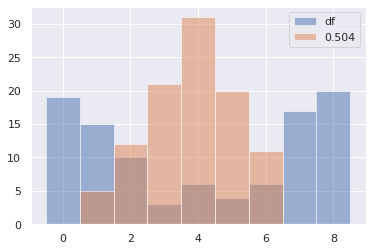

In [48]:
#生存確率0.504で、8個取り出すのを100回繰り返し、リストに格納
rng = np.random.RandomState(160)
y_list = rng.binomial(8,0.504,100)

plt.hist(df["y"],bins=np.arange(10)-0.5,alpha=0.5,label="df")
plt.hist(y_list,bins=np.arange(10)-0.5,alpha=0.5,label="0.504")

plt.legend()

二項分布で説明しようとすると過分散の可能性

# GLMMの階層ベイズ

Stanで実装



In [5]:
#model

#Stanに辞書型でデータを引き渡す
ps_data2 = {
    "J":df.shape[0],
    "Y":df["y"]
}

#pystan用のコードを用いて,y=β０　+　rのモデルを定義
model = """
data {
  int<lower=0>J; #サンプルサイズ
  int<lower=0>Y[J]; #生存数
}

parameters {
  real beta; #全個体共通のパラメーター
  real r[J]; #個体差
  real <lower=0> s; #個体差のばらつき
}

# trans-param では、data及びparametersで
# 宣言されたパラメータと定数値から、
# 新たにサンプリングする変数を作ることができる
transformed parameters {
  real q[J];
  for (i in 1:J)
  q[i] = inv_logit(beta + r[i]);
}

model {
  for (i in 1:J)
  Y[i] ~ binomial(8,q[i]); #二項分布

  beta ~ normal(0,100); #betaの事前分布は100の正規分布
  for(i in 1:J)
  r[i] ~ normal(0,s); #rの事前分布は標準偏差ｓ

  s ~ uniform(0,10000); #sの事前分布は0-10000の一様分布
}
"""

# 階層ベイズモデルの事後分布推定と予測

<br>パラメータの事後分布からのMCMCサンプリングを行う。

In [6]:
import pystan as ps

stmodel2 = ps.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_64ee6d43c4ca933b1b46ddbcfca32a70 NOW.


In [7]:
# MCMCサンプリングのステップ数
n_iter = 1500

# MCMCサンプリングの反復数の指定(WinBUGSではデフォルト3)
n_chains = 3

# MCMCサンプリングの最初の何ステップの結果を使わないとするか(burnin)
n_warmup = 100

# MCMCサンプリングのステップのうち、何個飛ばしでサンプリング結果を記録するか
n_thin = 1

# NUTSアルゴリズムを使ってサンプリングの実行
fit2 = stmodel2.sampling(
    data=ps_data2,
    iter=n_iter,
    chains=n_chains,
    n_jobs=1,
    warmup=n_warmup,
    algorithm="NUTS",
    thin=n_thin,
    seed=0)

print(fit2)

Inference for Stan model: anon_model_64ee6d43c4ca933b1b46ddbcfca32a70.
3 chains, each with iter=1500; warmup=100; thin=1; 
post-warmup draws per chain=1400, total post-warmup draws=4200.

          mean se_mean     sd   2.5%    25%    50%     75%  97.5%  n_eff   Rhat
beta      0.03    0.01   0.35  -0.66   -0.2   0.03    0.27   0.71    856    1.0
r[1]     -3.89    0.04   1.82  -8.25  -4.92  -3.67   -2.59  -1.02   1950    1.0
r[2]     -1.21    0.01   0.91  -3.11  -1.78  -1.18   -0.57   0.47   5037    1.0
r[3]      2.01    0.02   1.12   0.08   1.24   1.92    2.71    4.5   4700    1.0
r[4]      3.81    0.04   1.78   0.98   2.53   3.59    4.87   7.85   2149    1.0
r[5]     -2.06    0.02    1.1  -4.44  -2.74  -1.98    -1.3  -0.18   5017    1.0
r[6]       2.0    0.02   1.09   0.15   1.24   1.91    2.67   4.44   4059    1.0
r[7]      3.85    0.04   1.77   1.04   2.58   3.64    4.92   7.95   2333    1.0
r[8]      3.81    0.04   1.77   0.96   2.54   3.59    4.87   7.71   2537    1.0
r[9]     -2.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0c0744efd0>,
      dtype=object)

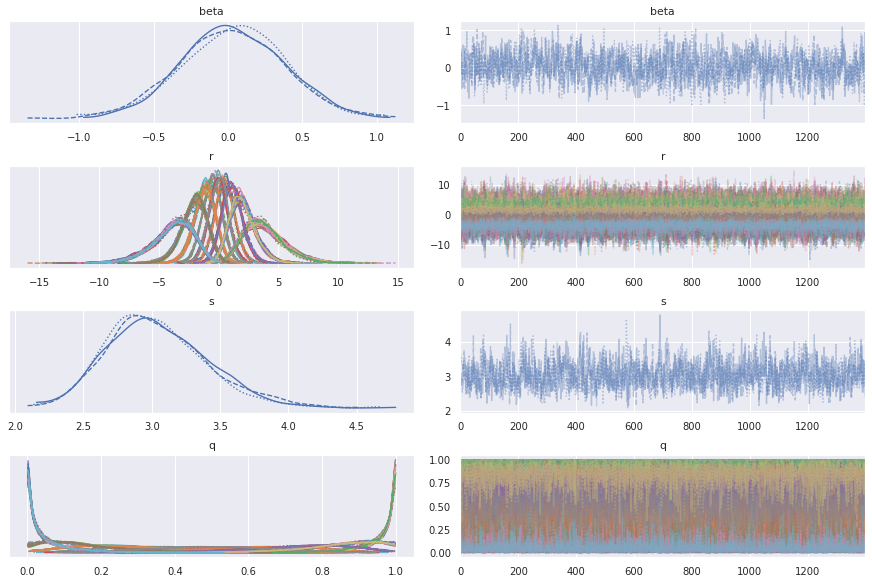

In [8]:
import arviz as az

az.plot_trace(fit2)

In [32]:
result = fit2.extract() #mcmcの結果を格納

sample_df = pd.DataFrame()
sample_df["beta"] = result["beta"] #データフレームを作って切片のパラメータを格納 

for i in range(result["r"].shape[1]):
  column_name = "r"+str(i+1)
  sample_df[column_name] = result["r"][:,i]

sample_df["s"] = result["s"]
for i in range(result["q"].shape[1]):
  column_name = "s"+str(i+1)
  sample_df[column_name] = result["q"][:,i]


In [33]:
sample_df #mcmcの結果を格納したDataFrame

,beta,r1,r2,r3,r4,r5,r6,r7,r8,r9,r10,r11,r12,r13,r14,r15,r16,r17,r18,r19,r20,r21,r22,r23,r24,r25,r26,r27,r28,r29,r30,r31,r32,r33,r34,r35,r36,r37,r38,r39,...,s61,s62,s63,s64,s65,s66,s67,s68,s69,s70,s71,s72,s73,s74,s75,s76,s77,s78,s79,s80,s81,s82,s83,s84,s85,s86,s87,s88,s89,s90,s91,s92,s93,s94,s95,s96,s97,s98,s99,s100
0,-0.330044,-5.200610,-1.240181,1.410764,5.195943,-1.299318,3.629092,2.884242,6.683469,-0.144547,-1.094204,-0.064534,-3.312939,-1.730301,0.978199,1.210922,7.315331,2.352317,-4.308720,-0.864418,-0.866675,-0.532223,-0.465314,1.820902,2.323106,2.039216,-0.676800,2.604324,0.548390,-0.065355,-8.254489,5.644134,3.164587,5.081055,-3.687767,0.337109,1.895049,0.876179,7.693260,-2.425072,...,0.001112,0.156915,0.214651,0.998787,0.878130,0.970744,0.904399,0.797233,0.005164,0.051622,0.178075,0.352464,0.115701,0.003140,0.006374,0.080019,0.997475,0.152325,0.855158,0.481564,0.910732,0.221897,0.351747,0.500614,0.940759,0.072159,0.993615,0.024710,0.978784,0.804695,0.522682,0.189429,0.909968,0.784977,0.597722,0.083779,0.152098,0.578890,0.992433,0.000304
1,-0.173074,-6.783583,-0.649738,1.637639,4.768078,-0.873500,3.568554,6.250539,4.576666,-1.930911,-2.059551,0.504915,-1.851653,-1.323563,0.807147,2.480348,6.562255,4.063122,-2.333708,-1.549546,-0.880130,-0.913005,-2.070890,0.126470,1.191884,4.007071,-0.804265,4.930385,0.636308,3.427967,-1.458246,1.566361,3.483940,5.029539,-1.037263,0.037477,1.377379,1.860735,9.625021,-1.370385,...,0.001840,0.099829,0.193867,0.997469,0.905842,0.949497,0.902369,0.974002,0.010832,0.002322,0.005297,0.480143,0.500879,0.084729,0.048493,0.042892,0.886790,0.011991,0.975222,0.536279,0.701336,0.434328,0.110712,0.649441,0.952175,0.067467,0.994695,0.010991,0.939528,0.799706,0.405352,0.137203,0.991129,0.487907,0.862335,0.156665,0.009865,0.402676,0.645027,0.059124
2,0.260287,-8.992908,-0.107169,1.057435,2.817584,-2.937930,2.280968,6.816305,5.268319,-3.171306,-1.765488,0.609552,-4.328242,-4.762488,-0.741437,3.149799,11.664650,4.262785,-7.260708,-1.377118,-0.257007,-5.446272,-2.345017,0.752360,2.798210,2.168249,-1.044095,8.544014,-1.560029,0.349483,-5.043539,0.643097,0.610347,6.335919,-6.481545,0.029593,0.460251,3.222609,3.690447,-0.762217,...,0.000697,0.088962,0.288872,0.996329,0.739095,0.908931,0.914648,0.988719,0.067635,0.006761,0.003577,0.552330,0.114721,0.062903,0.002185,0.068238,0.999260,0.125349,0.986722,0.468731,0.860412,0.308170,0.198169,0.472358,0.888304,0.001444,0.961905,0.466104,0.965364,0.881185,0.889570,0.255693,0.991664,0.770532,0.584056,0.019969,0.057624,0.633925,0.926362,0.119426
3,-0.130875,-3.636272,-0.564562,1.857969,5.578598,-2.338103,1.461376,6.017311,3.859026,-2.001080,-1.309262,-0.260810,-6.113644,-3.033430,-0.359364,3.098186,12.394194,4.880793,-7.562413,-1.482885,-0.403754,-1.111691,-1.725076,-0.746574,1.880015,6.931879,-0.269621,4.683303,-1.702575,3.885984,-6.406342,3.273221,0.972593,7.282734,-3.738814,-2.165205,0.459143,3.651282,6.616689,-0.666653,...,0.000277,0.125649,0.297655,0.998363,0.445973,0.976734,0.994218,0.982494,0.034411,0.037375,0.015943,0.563658,0.229657,0.021803,0.000077,0.105906,0.960818,0.150619,0.999697,0.701178,0.804301,0.180302,0.042275,0.655547,0.938161,0.032101,0.978194,0.035585,0.988511,0.757484,0.724054,0.446361,0.959331,0.842236,0.795949,0.120484,0.211741,0.572967,0.792378,0.091855
4,-0.072960,-4.238179,-1.473390,0.954473,4.354005,-0.273559,1.702615,4.694994,2.539020,-2.335491,-1.446361,-0.418768,-4.100716,-1.723898,0.188738,0.083311,3.459441,1.339053,-3.666267,-0.444727,-0.979843,-2.217564,-1.859876,0.413232,4.811047,2.415022,0.261272,2.853194,-0.071671,1.976396,-5.115750,2.480842,1.692993,5.454449,-2.463479,-1.729518,0.840201,-0.262261,3.247279,-1.437032,...,0.082582,0.075218,0.303472,0.997879,0.975156,0.663495,0.737141,0.896503,0.330820,0.001541,0.043535,0.670410,0.119984,0.026838,0.006380,0.097326,0.949957,0.130340,0.891724,0.504999,0.909005,0.129042,0.175810,0.499291,0.822101,0.029060,0.962513,0.065481,0.989776,0.830019,0.614416,0.230751,0.919969,0.504086,0.923519

# 格事後分布 <br>

β（切片）の事後分布


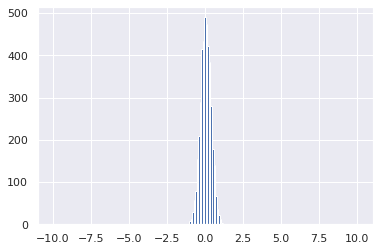

In [34]:
plt.hist(sample_df["beta"],bins=np.linspace(-10,10,200))
plt.show()

sの事後分布

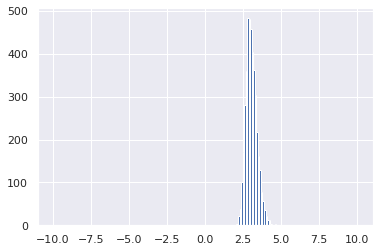

In [36]:
plt.hist(sample_df["s"],bins=np.linspace(-10,10,200))
plt.show()

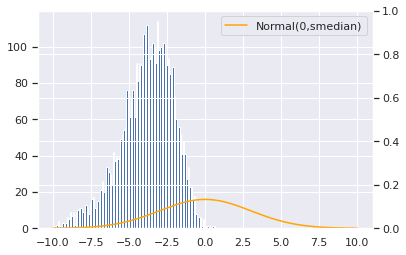

In [40]:
fig,ax1 = plt.subplots()
ax1.hist(sample_df["r1"],bins=np.linspace(-10,10,200)) #sの事後分布

#sが事後分布の中央値である場合の事前分布
ax2 = ax1.twinx() #2軸

smedian = sample_df["s"].median()

x = np.linspace(-10,10,2000)
y = (1.0/np.sqrt(2*np.pi*(smedian**2))) * np.exp(-(x**2)/(2*(smedian**2)))
ax2.plot(x,y,"orange",label="Normal(0,smedian)")
ax2.set(ylim=(0,1))

plt.legend()
plt.show()

# 事後分布から予測

In [50]:
pred_df = pd.DataFrame()

for i in range(9):
  column_name = "s"+str(i)
  pred_df[column_name] = np.zeros(1500) #0のデータを1500個格納

#DataFrameオブジェクトのiterrows()メソッドでは、行番号とSeriesがリストとして返ってくる。
#変数を2つ用意すると、それぞれに格納される。
for i,params in sample_df[["beta","s"]].iterrows():
  beta = params[0]
  s = params[1]

  survival_seeds_list = []
  for _ in range(100):
    r = rng.normal( 0, s, 1)
    q = 1/(1+np.exp(-(beta+r)))
    
    survival_seeds_list.append(rng.binomial(8,q,1))
    
  unique, counts = np.unique(survival_seeds_list, return_counts=True)
    
  for u,c in zip(unique,counts):
    pred_df.loc[i,"s"+str(u)] = c

In [51]:
pred_df

,s0,s1,s2,s3,s4,s5,s6,s7,s8
0,23.0,13.0,8.0,5.0,10.0,5.0,8.0,9.0,19.0
1,20.0,15.0,7.0,11.0,8.0,7.0,6.0,9.0,17.0
2,17.0,11.0,11.0,5.0,4.0,5.0,7.0,10.0,30.0
3,26.0,10.0,7.0,4.0,5.0,8.0,2.0,14.0,24.0
4,28.0,6.0,8.0,4.0,5.0,6.0,12.0,11.0,20.0
...,...,...,...,...,...,...,...,...,...
4195,23.0,12.0,9.0,5.0,9.0,4.0,4.0,11.0,23.0
4196,21.0,14.0,5.0,11.0,7.0,12.0,2.0,9.0,19.0
4197,26.0,14.0,7.0,4.0,5.0,7.0,7.0,11.0,19.0
4198,19.0,14.0,2.0,5.0,8.0,11.0,10.0,9.0,22.0


# 個体差と場所差を含んだ階層モデル

In [42]:
https://raw.githubusercontent.com/takitsuba/midoribon/master/Chap10/input/d1.csv

<generator object DataFrame.iterrows at 0x7f0bf601cc50>

In [79]:
#Git上からデータをインポート

import urllib.request
from io import StringIO

url ="https://raw.githubusercontent.com/takitsuba/midoribon/master/Chap10/input/d1.csv"

#csvを読み込む関数
def read_csv(url):
    print(url)
    res = urllib.request.urlopen(url)
    res = res.read().decode("utf-8")
    df = pd.read_csv(StringIO(res))
    return df

df = read_csv(url)

https://raw.githubusercontent.com/takitsuba/midoribon/master/Chap10/input/d1.csv


In [55]:
df

,id,pot,f,y
0,1,A,C,6
1,2,A,C,3
2,3,A,C,19
3,4,A,C,5
4,5,A,C,0
...,...,...,...,...
95,96,J,T,1
96,97,J,T,1
97,98,J,T,2
98,99,J,T,1


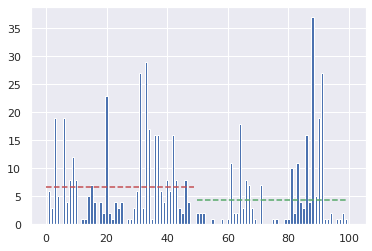

In [63]:
#図１０.７

plt.bar(df["id"],df["y"])

#施肥未処理
mean_C = df.groupby("f")["y"].mean()["C"]
#施肥処理
mean_T = df.groupby("f")["y"].mean()["T"]

plt.plot(np.arange(50),[mean_C]*50, "r--")
plt.plot(np.arange(50,100),[mean_T]*50, "g--")

In [64]:
#無処理の平均
print(mean_C)
#ポアソン分布に従うと仮定すると標準偏差は平均の平方根
print(np.sqrt(mean_C))

6.64
2.5768197453450252


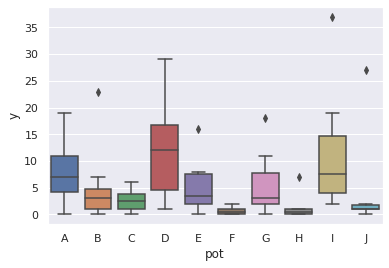

In [65]:
sns.boxplot(x="pot",y="y",data=df)

In [85]:
#Stanに辞書型でデータを引き渡す
ps_data = {
    "N_sample":df.shape[0],
    "Y":df["y"],
    "N_pot":df.pot.drop_duplicates().shape[0], #重複した行を抽出
    "N_sigma": 2,
    "F":(df["f"]).astype("category").cat.codes +1,
    "Pot":(df["pot"]).astype("category").cat.codes +1
}

#pystan用のコードを用いて,y=β０　+　rのモデルを定義
model = """
data {
  int<lower=0>N_sample; #サンプルサイズ
  int<lower=0>N_pot; #ポットの数
  int<lower=0>N_sigma; #sigmaの数
  int<lower=0>Y[N_sample]; #種の数
  int<lower=0>F[N_sample]; #施肥の有無
  int<lower=0>Pot[N_sample]; # potの数
}
parameters {
  real beta1; #切片
  real beta2; #施肥の係数
  real r[N_sample]; #個体差
  real rp[N_pot]; #ポットの違い
  real<lower=0>sigma[N_sigma];#無情報事前分布のパラメーターを用意
}

# trans-param では、data及びparametersで
# 宣言されたパラメータと定数値から、
# 新たにサンプリングする変数を作ることができる
transformed parameters {
  real lambda[N_sample];

  for (i in 1:N_sample){
  lambda[i] = exp(beta1 + beta2 * F[i] + r[i] + rp[Pot[i]]);
  }
}

model {
  for (i in 1:N_sample){
    Y[i] ~ poisson(lambda[i]);
  }

  beta1 ~ normal(0,100); #beta1の事前分布は100の正規分布
  beta2 ~ normal(0,100);
  r ~ normal(0,sigma[1]); #rの事前分布は標準偏差ｓigma1
  rp ~ normal(0,sigma[2]); #rの事前分布は標準偏差ｓigma2

  for (k in 1:N_sigma){
    sigma[k] ~ uniform(0,10000); #sigmaの事前分布は0-10000の一様分布
  }
}
"""

In [86]:
stmodel2 = ps.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_86d9dec40d83dfe6afbcbfa380582a84 NOW.


In [77]:
df["f"]

0     0
1     0
2     0
3     0
4     0
     ..
95    1
96    1
97    1
98    1
99    1
Name: f, Length: 100, dtype: int8

In [87]:
# MCMCサンプリングのステップ数
n_iter = 1500

# MCMCサンプリングの反復数の指定(WinBUGSではデフォルト3)
n_chains = 3

# MCMCサンプリングの最初の何ステップの結果を使わないとするか(burnin)
n_warmup = 100

# MCMCサンプリングのステップのうち、何個飛ばしでサンプリング結果を記録するか
n_thin = 1

# NUTSアルゴリズムを使ってサンプリングの実行
fit2 = stmodel2.sampling(
    data=ps_data,
    iter=n_iter,
    chains=n_chains,
    n_jobs=1,
    warmup=n_warmup,
    algorithm="NUTS",
    thin=n_thin,
    seed=0)

print(fit2)

Inference for Stan model: anon_model_86d9dec40d83dfe6afbcbfa380582a84.
3 chains, each with iter=1500; warmup=100; thin=1; 
post-warmup draws per chain=1400, total post-warmup draws=4200.

              mean se_mean     sd   2.5%    25%    50%     75%  97.5%  n_eff   Rhat
beta1         2.26    0.03   1.13   0.04   1.53   2.25    2.96   4.59   1341    1.0
beta2        -0.87    0.02   0.71  -2.31  -1.31  -0.87   -0.41   0.53   1446    1.0
r[1]         -0.04  6.8e-3   0.47  -1.03  -0.34  -0.02     0.3   0.83   4835    1.0
r[2]          -0.6  7.6e-3   0.56  -1.79  -0.96  -0.58   -0.21   0.42   5487    1.0
r[3]           1.1  5.8e-3   0.39   0.35   0.83   1.09    1.36   1.85   4446    1.0
r[4]         -0.19  7.0e-3   0.49  -1.17  -0.51  -0.18    0.14   0.72   4840    1.0
r[5]         -1.56  9.7e-3   0.71  -3.14   -2.0  -1.51   -1.07  -0.28   5428    1.0
r[6]           1.1  5.7e-3   0.39   0.31   0.83   1.11    1.36   1.86   4748    1.0
r[7]         -0.38  7.2e-3   0.52  -1.45  -0.73  -0.37  

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0c0f8454d0>,
      dtype=object)

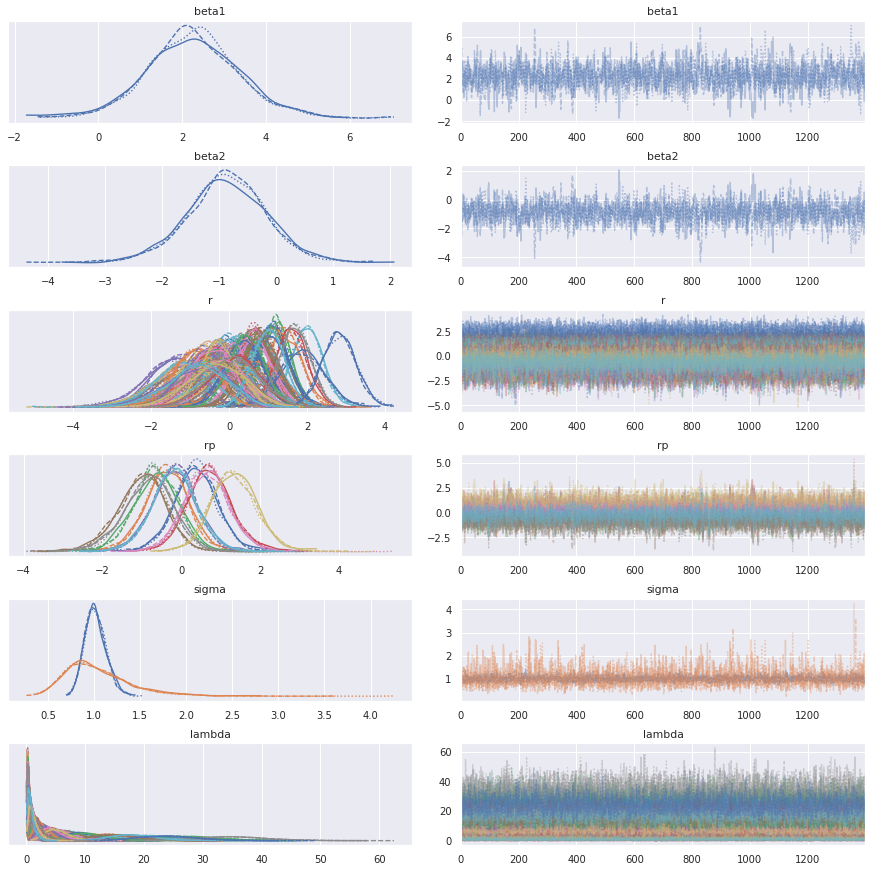

In [88]:
import arviz as az

az.plot_trace(fit2)